In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# device configuration
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [9]:
#hyper parameters 
num_epochs=5
batch_size=4
learning_rate=.001

dataset has PILImage images of range [0, 1]. 
 We transform them to Tensors of normalized range [-1, 1]

In [10]:
#transform
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,.5,.5),(.5,.5,.5))])

#### CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

In [11]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [13]:
#get some random trainnig images
dataiter=iter(train_loader)
images,labels=next(dataiter)

In [14]:
# plotting the data
def imshow(img):
    img=img/2+.05  #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


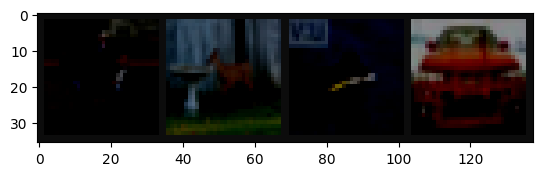

In [15]:
#show images
imshow(torchvision.utils.make_grid(images))

In [26]:
# cnn class

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

In [28]:
model=ConvNet().to(device)

In [29]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [30]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/5], Step [2000/12500], Loss: 2.3452
Epoch [1/5], Step [4000/12500], Loss: 2.3058
Epoch [1/5], Step [6000/12500], Loss: 2.2987
Epoch [1/5], Step [8000/12500], Loss: 2.3058
Epoch [1/5], Step [10000/12500], Loss: 2.3092
Epoch [1/5], Step [12000/12500], Loss: 2.2948
Epoch [2/5], Step [2000/12500], Loss: 2.2747
Epoch [2/5], Step [4000/12500], Loss: 2.3081
Epoch [2/5], Step [6000/12500], Loss: 2.3164
Epoch [2/5], Step [8000/12500], Loss: 2.0440
Epoch [2/5], Step [10000/12500], Loss: 1.5983
Epoch [2/5], Step [12000/12500], Loss: 1.7935
Epoch [3/5], Step [2000/12500], Loss: 2.6469
Epoch [3/5], Step [4000/12500], Loss: 2.1766
Epoch [3/5], Step [6000/12500], Loss: 1.4620
Epoch [3/5], Step [8000/12500], Loss: 1.9569
Epoch [3/5], Step [10000/12500], Loss: 1.2450
Epoch [3/5], Step [12000/12500], Loss: 1.1230
Epoch [4/5], Step [2000/12500], Loss: 1.4554
Epoch [4/5], Step [4000/12500], Loss: 1.5107
Epoch [4/5], Step [6000/12500], Loss: 1.7521
Epoch [4/5], Step [8000/12500], Loss: 1.3121
Epoc

In [31]:
PATH='./cnn.pth'
torch.save(model.state_dict(),PATH)

In [35]:
with torch.no_grad():
    n_correct=0
    n_samples=0
    n_class_correct=[0 for i in range(10)]
    n_class_samples=[0 for i in range(10)]
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        #max returns (value,index)
        _,predicted=torch.max(outputs,1)
        n_samples+=labels.shape[0]
        n_correct+=(predicted==labels).sum().item()
        for i in range(batch_size):
            label=labels[i]
            pred=predicted[i]
            if (label==pred):
                n_class_correct[label]+=1
            n_class_samples[label]+=1
    acc=(n_correct/n_samples)*100.0
    print(f"accuracy of the model:{acc}%")

    #accuracy for each class
    for i in range(10):
        acc=(n_class_correct[i]/n_class_samples[i])*100.0
        print(f"accuracy of {classes[i]}: {acc:.2f}%")

accuracy of the model:47.22%
accuracy of plane: 55.80%
accuracy of car: 61.30%
accuracy of bird: 17.30%
accuracy of cat: 24.80%
accuracy of deer: 47.40%
accuracy of dog: 46.70%
accuracy of frog: 63.80%
accuracy of horse: 52.80%
accuracy of ship: 54.10%
accuracy of truck: 48.20%
